Webscraping and prediction

In [1]:
#check if virtual env is running (required to run the rest of the code)
import sys
print(sys.prefix != sys.base_prefix)
print(sys.version)
sys.executable


True
3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]


'/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/bin/python'

/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


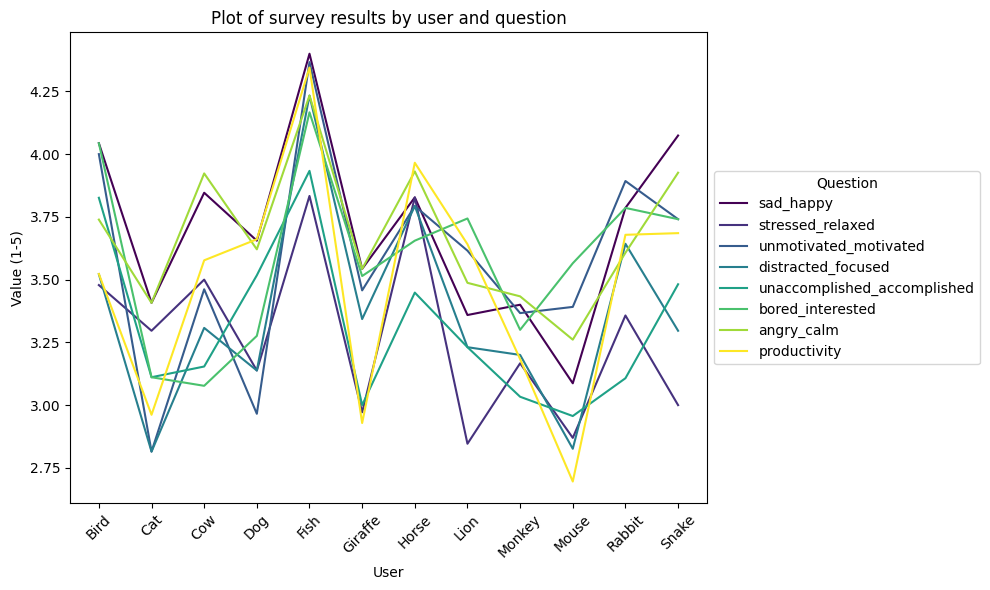

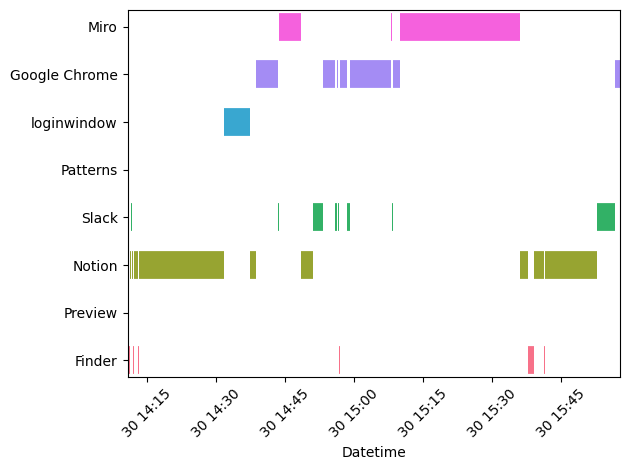

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import bs4, requests

import pandas as pd
import numpy as np
import ipynb
import os
import seaborn as sns
from ipynb.fs.full.SurveyUpload import uploadSurvey
from ipynb.fs.full.DataUpload import getPatterns
import openai
import requests
import json
import time
import matplotlib.pyplot as plt
import re
from dotenv import load_dotenv

import traceback
import logging

USE LOCAL LLM TO PREDICT:


use llama model


In [3]:
def predictLocal(site, model="google/flan-t5-base", lst = ['Professional Resources & Tools', 'Communication & Collaboration', 'Research & Information Gathering', 'News & Current Events', 'Social Media & Networking', 'Entertainment', 'Shopping', 'Financial & Administrative', 'Personal Interest ','Education & Development'], \
            webscrape=False):
    #set up model
    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForSeq2SeqLM.from_pretrained(model)

    #turn list into string
    catList = ', '.join(lst)

    #webscrape if asked for it:
    if webscrape:
        response = requests.get(site,headers={'User-Agent': 'Mozilla/5.0'})
        soup = bs4.BeautifulSoup(response.text,'html.parser')
        scraped_text = soup.body.get_text(' ', strip=True)

        input_text = "In which of these possible categories: " + catList + \
                " does the following website or app best fit? This is the site \
                name: " + site + " And this is the full scraped text from the \
                website: " + scraped_text


    if not webscrape:
        input_text = "In which of these possible categories: " + catList + \
             " does the following website or app best fit? " + site

    input_text = input_text[:512]
    #input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    outputs = model.generate(input_ids)

    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    match = re.search(r"\b(?!<pad>|</s>)\w+\b", decoded_output)
    if match:
        result = match.group()
    else:
        result = decoded_output.split()[1]

    print(result)
    return result

USE OPENAI'S API TO PREDICT (Careful using my API key):

In [4]:
#This is setup so that my api key autofills on my personal computer. However, 
#running this on a different computer will require you to input your own api key

load_dotenv()  # loads the .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
openai.api_key = OPENAI_API_KEY
openai.Model.list()

<OpenAIObject list at 0x12ae7aed0> JSON: {
  "object": "list",
  "data": [
    {
      "id": "davinci",
      "object": "model",
      "created": 1649359874,
      "owned_by": "openai",
      "permission": [
        {
          "id": "modelperm-uJaD4C9nXA6tPNoBII9hcYF4",
          "object": "model_permission",
          "created": 1692634268,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": false,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ],
      "root": "davinci",
      "parent": null
    },
    {
      "id": "text-davinci-001",
      "object": "model",
      "created": 1649364042,
      "owned_by": "openai",
      "permission": [
        {
          "id": "modelperm-CDlahk1RbkghXDjtxqzXoPNo",
          "object": "model_permission",
          "created": 1690913868,


In [5]:
def predictGPT(site, title="Title not found", gpt_model="gpt-3.5-turbo", 
               lst=['Professional Resources & Tools', 'Communication & Collaboration', 'Research & Information Gathering', 
                    'News & Current Events', 'Social Media & Networking', 'Entertainment', 'Shopping', 
                    'Financial & Administrative', 'Personal Interest','Education & Development'],
               webscrape=False, include_title=True):

    catList = ', '.join(lst)
    user_message = f"In which of these possible categories: {catList} does the following website or app best fit? This is its name: {site}"

    # webscrape if asked for it 
    if webscrape:
        response = requests.get(site, headers={'User-Agent': 'Mozilla/5.0'})
        soup = bs4.BeautifulSoup(response.text, 'html.parser')
        scraped_text = soup.body.get_text(' ', strip=True)[:1000]
        user_message += f" And this is the full scraped text from the website: {scraped_text}"

    # include title of webpage 
    elif include_title:
        user_message += f" This is its title: {title}"

    category = openai.ChatCompletion.create(
        model=gpt_model,
        temperature=0.5,
        messages=[
            {"role": "system", "content": "You are a website and app classification assistant. Don't include any explanations in your responses."},
            {"role": "user", "content": user_message}
        ]
    )

    return category["choices"][0]["message"]["content"]


Lukas' category code

In [39]:
#question for Lukas - does this function autofill its own required inputs? otherwise where does urlCategoryArray come from?

def categorize(sites, gpt_model="gpt-3.5-turbo", 
               lst=['Professional Resources & Tools', 'Communication & Collaboration', 'Research & Information Gathering', 
                    'News & Current Events', 'Social Media & Networking', 'Entertainment', 'Shopping', 
                    'Financial & Administrative', 'Personal Interest','Education & Development']):

    catList = ', '.join(lst)
    user_message = "URLs: " + ", ".join(" -- ".join(map(str, tpl)) for tpl in sites) + "Categories: " + catList


    categorize_function = [
        {
            "name": "categorizeUrls",
            "description": "Use this function to categorize URLs into the provided categories",
            "parameters": {
                "type": "object",
                "properties": {
                    "urlCategoryArray": {
                        "type": "array",
                        "description": "An array of tuples with the url name and its corresponding category",
                        "items": {
                            "type": "object",
                            "description": "a tuple with url name and its corresponding category",
                            "properties": {
                                "url": {
                                    "type":"string",
                                    "description":"url"
                                },
                                "category": {
                                    "type":"string",
                                    "description":"a single category chosen from the categories provided"
                                }
                            },
                            "required":["url","category"]
                        }
                    }
                },
                "required": ["urlCategoryArray"]
            }
        }
    ]

    try:
        print("Making request to OPENAI API...")

        result = openai.ChatCompletion.create(
            model=gpt_model,
            temperature=0.5,
            messages=[
                {"role": "system", "content": "You are a website and app classification assistant. Don't include any explanations in your responses."},
                {"role": "user", "content": user_message}
            ],
            functions=categorize_function,
            function_call= {
                "name": "categorizeUrls"
            }
        )
        #print(result.choices[0].message["function_call"]["arguments"])
        return json.loads(result.choices[0].message["function_call"]["arguments"])
    except Exception as e:
        logging.error(traceback.format_exc())
        



Testing each method:

In [12]:
sites = [('Google Chrome', 'Meet - Design sync'), ('Weather', ''), ('Google Chrome', 'Participant list - Google Sheets'), ('https://eu.mixpanel.com/', 'Onboarding Funnel - Beams-Mac-Bar-Production / Mixpanel')]


In [43]:
test = categorize(sites=sites)

Making request to OPENAI API...


In [44]:
print(test)

{'urlCategoryArray': [{'url': 'Google Chrome - Meet - Design sync', 'category': 'Communication & Collaboration'}, {'url': 'Weather -', 'category': 'News & Current Events'}, {'url': 'Google Chrome - Participant list - Google Sheets', 'category': 'Professional Resources & Tools'}, {'url': 'https://eu.mixpanel.com/ - Onboarding Funnel - Beams-Mac-Bar-Production / Mixpanel', 'category': 'Research & Information Gathering'}]}


In [42]:
for entry in test['urlCategoryArray']:
    print(entry['category'])

Communication & Collaboration
News & Current Events
Professional Resources & Tools
Research & Information Gathering


In [10]:
#set parameters - defaults are usually covered by the function, so this is only if you want to make custom changes
model = "google/flan-t5-base"
sitelist = ["https://nytimes.com/", "https://youtube.com/", "https://twitter.com/", "https://amazon.com/", \
    "https://chat.openai.com/", "https://stackoverflow.com/", "https://code.visualstudio.com/"]
lst = ['Professional Resources & Tools', 'Communication & Collaboration', 'Research & Information Gathering', 'News & Current Events', 'Social Media & Networking', 'Entertainment', 'Shopping', 'Financial & Administrative', 'Personal Interest','Education & Development']
site = "https://nytimes.com/"

In [11]:
#predictLocal(site, webscrape=True)
predictGPT(site, webscrape=True, include_title=True)
predictGPT(site, webscrape=False, include_title=True)
predictGPT(site, webscrape=False, include_title=False)
#predictGPT_list(sitelist)

'News & Current Events'

Graphing comparison of speed of local LLM vs OpenAI API

In [89]:
def compare_execution_time(site):
    
    times = {'predictLocal': [], 'predictGPT': []}

    # Measure time taken by predictLocal
    for webscrape in [False, True]:
        # Measure time for predictLocal
        start_time = time.time()
        predictLocal(site, webscrape=webscrape)
        local_time = time.time() - start_time
        times['predictLocal'].append(local_time)

        # Measure time for predictGPT
        start_time = time.time()
        predictGPT(site, webscrape=webscrape)
        gpt_time = time.time() - start_time
        times['predictGPT'].append(gpt_time)

    # Prepare data for visualization
    labels = ['webscrape=False', 'webscrape=True']
    bar_width = 0.35
    index = np.arange(len(labels))

    # Create double bar graph
    plt.bar(index, times['predictLocal'], bar_width, label='predictLocal', color='blue')
    plt.bar(index + bar_width, times['predictGPT'], bar_width, label='predictGPT', color='green')
    
    plt.xlabel('Webscrape Setting')
    plt.ylabel('Time (seconds)')
    plt.title('Comparison of Execution Times')
    plt.xticks(index + bar_width / 2, labels)  # Positioning the label in the center of the double bars
    plt.legend()
    plt.tight_layout()
    plt.show()


website
news
news
news


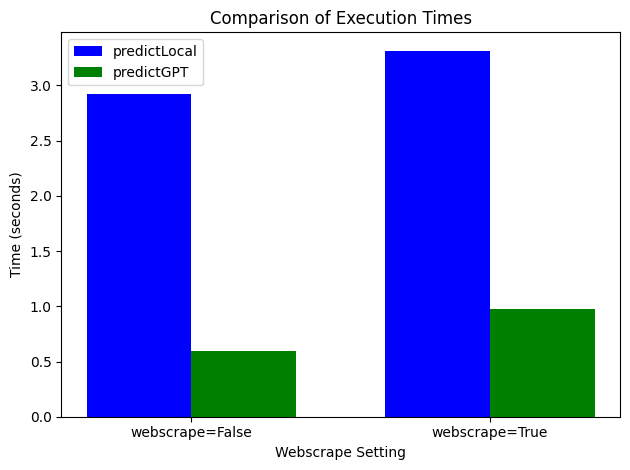

In [93]:
compare_execution_time(site)

Testing accuracy of local LLM vs gpt-3.5 (gpt with webscrape is assumed to always be correct)

In [118]:
def compare_accuracy(sitelist):
    
    predictions = {'yes_webscrape': [], 'no_webscrape': [], 'gpt': []}
    accuracy = {"Webscrape": 0, "No Webscrape": 0}
    guessed_wrong = {"Webscrape": [], "No Webscrape": []}
    total_sites = len(sitelist)

    #make predictions for each site
    for site in sitelist:
        predictions["gpt"].append(predictGPT(site, webscrape=True))
        predictions["yes_webscrape"].append(predictLocal(site, webscrape=True))
        predictions["no_webscrape"].append(predictLocal(site, webscrape=False))

    #check accuracy of predictions

    for idx in range(total_sites):
        if predictions["yes_webscrape"][idx] == predictions["gpt"][idx]:
            accuracy["Webscrape"] += 1
        else:
            guessed_wrong["Webscrape"].append((sitelist[idx], predictions["yes_webscrape"][idx]))
        if predictions["no_webscrape"][idx] == predictions["gpt"][idx]:
            accuracy["No Webscrape"] += 1
        else:
            guessed_wrong["No Webscrape"].append((sitelist[idx], predictions["no_webscrape"][idx]))
    
    accuracy["Webscrape"] = accuracy["Webscrape"]/total_sites
    accuracy["No Webscrape"] = accuracy["No Webscrape"]/total_sites


    labels = ['Webscrape', 'No Webscrape']
    accuracyList = [accuracy["Webscrape"], accuracy["No Webscrape"]]

    # Create bar graph
    plt.bar(labels, accuracyList, color=['blue', 'green'])
    
    plt.xlabel('Webscrape Setting')
    plt.ylabel('Accuracy %')
    plt.title('Comparison of Accuracy')
    plt.show()

    print("Missed Predictions:")
    print("-------------------------")
    print("Webscrape: ")
    for wrong in guessed_wrong["Webscrape"]:
        name, category = wrong
        print(name + "   as   " + category)
    print("..........")
    print("No Webscrape: ")
    for wrong in guessed_wrong["No Webscrape"]:
        name, category = wrong
        print(name + "   as   " + category)

In [ ]:
compare_accuracy(sitelist)